In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Making reading medical abstracts easier

We will be replicating the paper available [here](https://arxiv.org/abs/1710.06071).


In [66]:
!rm -rf pubmed-rct/
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct 
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 12.13 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [67]:
!ls pubmed-rct/PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


### Experimenting with 20k_RCT_numbers_replaced_with_at_sign

In [68]:
data_dir = "/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [69]:
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]

In [70]:
filenames

['/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocessing the data and visualizing it

In [71]:
# Function to read lines from a file
def get_lines(filename):
    """
    Reads a file and returns the lines as a list
    """
    with open(filename,'r') as f:
        return f.readlines()

In [72]:
# Reading in training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [73]:
len(train_lines)

210040

In [74]:
# We will store the data as a list of dictionaries with line_number, text, target, and total_lines as keys.
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries
    """
    input_lines = get_lines(filename)
    
    abstract_lines = ""
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
            
        elif line.isspace(): # This will check a new line
            abstract_line_split = abstract_lines.splitlines()
#             print(abstract_line_split)
            # Iterate through each line from the abstract
            for abstract_line_number,abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t') # Split target from text
#                 print(target_text_split)
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
                
        else:
            abstract_lines+=line
            
    return abstract_samples

In [75]:
# See how much time it takes
import time
s = time.perf_counter()
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print("Length of train samples:",len(train_samples))
print("Length of val samples:",len(val_samples))
print("Length of test samples:",len(test_samples))
e = time.perf_counter()
print("----------------------------------------------")
print("Time taken:",e-s)

Length of train samples: 180040
Length of val samples: 30212
Length of test samples: 30135
----------------------------------------------
Time taken: 0.59056957100006


In [77]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [78]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [79]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Checking the distribution of labels and lengths of lines

<AxesSubplot:>

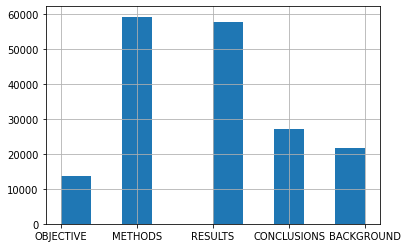

In [80]:
train_df['target'].hist()

<AxesSubplot:>

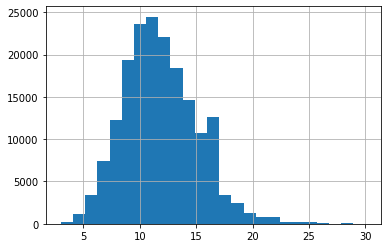

In [81]:
train_df['total_lines'].hist(bins=25)

### Get list of sentences

In [82]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

<AxesSubplot:>

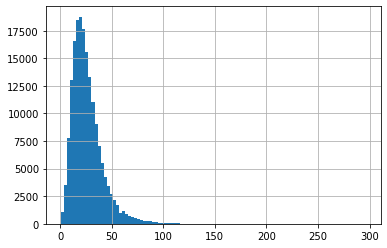

In [83]:
train_df['text'].map(lambda x:len(x.split())).hist(bins=100)

### Making numeric labels

In [84]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # If set to true, tf will give error as tf is not compatible with sparse matrices.
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
# train_labels_one_hot

In [85]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
#  = OneHotEncoder(sparse=False) # If set to true, tf will give error as tf is not compatible with sparse matrices.
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [86]:
# Get classes
class_names = label_encoder.classes_
len(class_names)

5

## Modelling experiments

### 1. A baseline Naive-Bayes model

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## What is Inverse document frequency and TF-IDF?
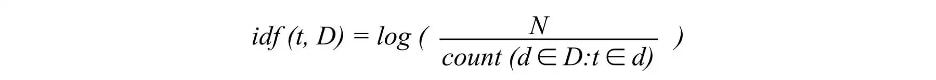
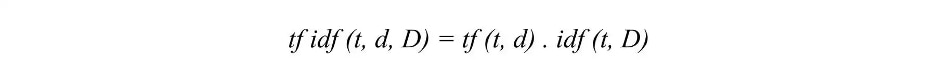

In [88]:
model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [89]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [90]:
baseline_preds = model_0.predict(val_sentences)

In [91]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2022-09-18 09:38:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-18 09:38:51 (53.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [92]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing data for deep sequence models

In [93]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [94]:
train_df['text'].map(lambda x:len(x.split())).mean()
# So we will have to pad shorter sentences and cut down on longer sentences to 
# keep sentence length to 26

26.338269273494777

<AxesSubplot:>

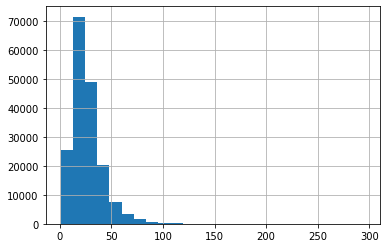

In [95]:
train_df['text'].map(lambda x:len(x.split())).hist(bins=25)
# If we take a limit on sentence length that covers around 95% of data, that will be good

In [96]:
print(np.percentile(train_df['text'].map(lambda x:len(x.split())),96.5))
print(np.percentile(train_df['text'].map(lambda x:len(x.split())),95))
# So it is 55. We can keep sentence length to 55 to cover 95% of the data without losing information.
# But we can also take 60 to cover 96.5% of the data

60.0
55.0


### Creating a text vectorizer

In [97]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000 # As given in the paper
output_sequence_length = int(np.percentile(train_df['text'].map(lambda x:len(x.split())),96.5))

# Max-tokens is the maximum unique words it can handle, kind of cap for the vocab size
# Output sequence length is the length of output that we want, even if we have more words in vocab
# we can truncate the output vector length.
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,                         #68000
    output_sequence_length=output_sequence_length, #60
)

# Adapt to training data, as test data is meant to be unseen
text_vectorizer.adapt(train_sentences)

In [98]:
import random
t = random.choice(train_sentences)
print("Text:",t)
print("Length:",len(t))
print("Vectorized:",text_vectorizer([t]))

Text: sixteen patients were randomized to follow @ days ' voice rest and @ patients were randomized to @ days ' voice rest .
Length: 118
Vectorized: tf.Tensor(
[[3397   12    9   29    6 1532   84 2275 1240    3   12    9   29    6
    84 2275 1240    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 60), dtype=int64)


In [99]:
# Data exploration
rct_20k_vocab = text_vectorizer.get_vocabulary()
print("Total words:",len(rct_20k_vocab))
print("Most common ones:",rct_20k_vocab[:5])
print("Most uncommon ones:",rct_20k_vocab[-5:])

Total words: 64841
Most common ones: ['', '[UNK]', 'the', 'and', 'of']
Most uncommon ones: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Visualizing words in vocabulary

In [100]:
from wordcloud import WordCloud
# The more frequent a word, the bigger and bolder it is in the word cloud.

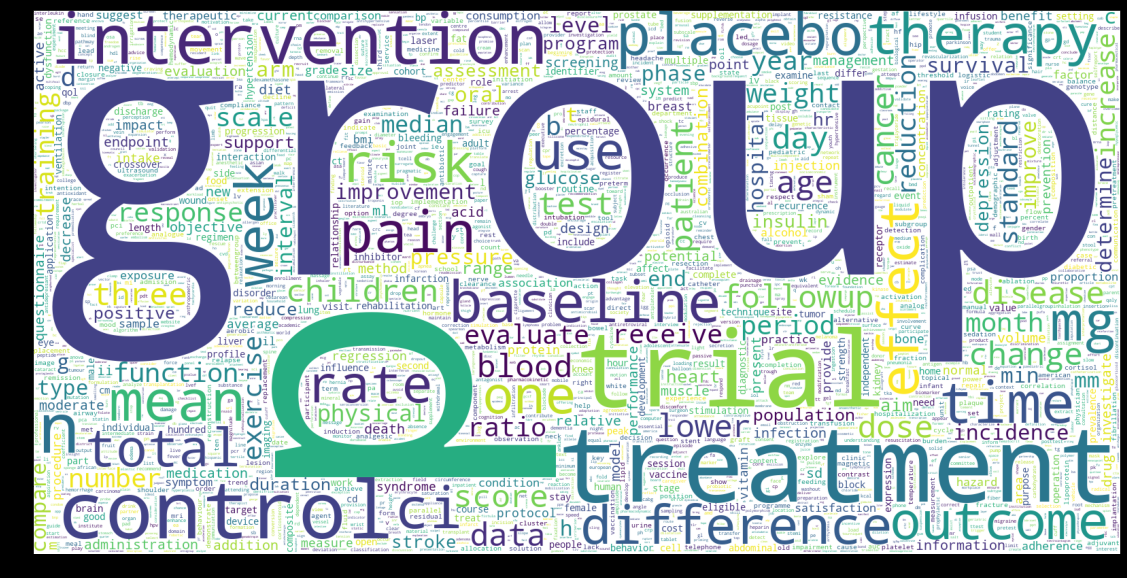

In [101]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white",width=1600, height=800,max_words=10000).generate(" ".join(rct_20k_vocab))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [102]:
# https://stackoverflow.com/questions/54557468/in-tf-keras-layers-embedding-why-it-is-important-to-know-the-size-of-dictionary
# Creating an embedding layer 
# When we pass a vectorized sentence into the embedding layer,
# it calculates a output_dim length vector for each integer in
# the vectorized sentence. It can take in variable length input.
# It needs input_dim to know the vocabulary, and to look-up,
# for an integer, what is its embedding.
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), # size of vocabulary
                               output_dim=128, # keep multiple of 8
                               mask_zero=True,
                               name="token_embedding"
                              )
# This embedding is random initially, it will improve upon training

In [103]:
len(rct_20k_vocab)

64841

In [104]:
print("Sentence:",t)
print("Vectorized:",text_vectorizer([t]))
print("Embedding:",token_embed(text_vectorizer([t])))

Sentence: sixteen patients were randomized to follow @ days ' voice rest and @ patients were randomized to @ days ' voice rest .
Vectorized: tf.Tensor(
[[3397   12    9   29    6 1532   84 2275 1240    3   12    9   29    6
    84 2275 1240    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 60), dtype=int64)
Embedding: tf.Tensor(
[[[ 0.02912224  0.03900642  0.0132893  ... -0.03323219 -0.00759687
    0.03687403]
  [ 0.03498315 -0.01265376  0.01528064 ... -0.01314707  0.0111863
    0.00577269]
  [-0.03594083  0.00059475  0.02254586 ... -0.03961643  0.00070752
    0.00439607]
  ...
  [ 0.01798784  0.01146703  0.01832863 ... -0.03601082 -0.04561194
   -0.04397831]
  [ 0.01798784  0.01146703  0.01832863 ... -0.03601082 -0.04561194
   -0.04397831]
  [ 0.01798784  0.01146703  0.01832863 ... -0.03601082 -0.0456119

## Creating fast loading dataset
[Better performance](https://www.tensorflow.org/guide/data_performance)

- We need to deliver data for the next step before the current step has finished in order to improve speed.
- When the model is training in step i, the input pipeline is fetching data for step (i+1).

In [105]:
# Convert data in tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [106]:
# We will turn these into pre-fetch datasets
# I am not shuffling the dataset, as we want to preserve order
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the 1st deep model

In [107]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
print(x.shape)
x = token_embed(x)
print(x.shape)
x = layers.Conv1D(64,3,padding='same')(x)
print(x.shape)
x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(5,activation='softmax')(x)
model1 = tf.keras.Model(inputs=inputs,outputs=outputs)

(None, 60)
(None, 60, 128)
(None, 60, 64)
(None, 64)


In [108]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [109]:
h1 = model1.fit(train_dataset,
               validation_data=val_dataset,
               epochs=5,
               steps_per_epoch=int(0.1*len(train_dataset)),
               validation_steps=int(0.1*len(val_dataset)))
# We seem to have beaten the baseline model

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9331 - accuracy: 0.6250 - val_loss: 0.6835 - val_accuracy: 0.7314
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6606 - accuracy: 0.7519 - val_loss: 0.6347 - val_accuracy: 0.7643
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6267 - accuracy: 0.7681 - val_loss: 0.6035 - val_accuracy: 0.7749
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5993 - accuracy: 0.7836 - val_loss: 0.5854 - val_accuracy: 0.7769
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6058 - accuracy: 0.7828 - val_loss: 0.5789 - val_accuracy: 0.7922


In [110]:
model1.evaluate(val_dataset)
# And here it is, we have won over the baseline 😅!

945/945 [==============================] - 3s 3ms/step - loss: 0.5804 - accuracy: 0.7931


[0.5803892016410828, 0.7931285500526428]

In [111]:
model1_pred_probs = model1.predict(val_dataset)
model1_preds = tf.argmax(model1_pred_probs,axis=1)

In [112]:
model1_pred_probs

array([[6.17438018e-01, 1.37112826e-01, 3.48858349e-02, 1.66565999e-01,
        4.39972691e-02],
       [5.07790387e-01, 3.41398567e-01, 1.15560098e-02, 1.16087794e-01,
        2.31672768e-02],
       [1.99633911e-01, 5.61435800e-03, 8.24369490e-04, 7.93913186e-01,
        1.41513083e-05],
       ...,
       [3.09706083e-05, 1.05058227e-03, 4.36667679e-03, 4.22116645e-05,
        9.94509637e-01],
       [1.61953971e-01, 2.30497897e-01, 1.33989617e-01, 7.98837021e-02,
        3.93674791e-01],
       [1.95202872e-01, 7.20403552e-01, 5.48475571e-02, 1.00835944e-02,
        1.94624607e-02]], dtype=float32)

In [113]:
model1_preds, class_names

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [114]:
model1_results = calculate_results(val_labels_encoded,model1_preds)
model1_results
# Better than baseline

{'accuracy': 79.31285581887991,
 'precision': 0.7991324765209971,
 'recall': 0.7931285581887991,
 'f1': 0.7924209227599421}

## Using pretrained feature extractor

https://tfhub.dev/google/universal-sentence-encoder/4

In [115]:
import tensorflow_hub as hub
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                trainable=False,
                name="universal_sentence_encoder")
# This embedding layer converts a text sentence into a 512 length vector

In [116]:
inputs = layers.Input(shape=[],dtype=tf.string) # expects list as input
x = embed(inputs)
print(x.shape)
# x = layers.Conv1D(64,5,padding='same')(x)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dense(32,activation='relu')(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(5,activation="softmax")(x)
model2 = tf.keras.Model(inputs,outputs)

model2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

(None, 512)


In [117]:
h2 = model2.fit(train_dataset,
               validation_data=val_dataset,
               epochs=5,
               steps_per_epoch=int(0.1*len(train_dataset)),
               validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 9s 13ms/step - loss: 0.9191 - accuracy: 0.6284 - val_loss: 0.7864 - val_accuracy: 0.6938
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7448 - accuracy: 0.7115 - val_loss: 0.7161 - val_accuracy: 0.7214
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7147 - accuracy: 0.7240 - val_loss: 0.6830 - val_accuracy: 0.7314
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6822 - accuracy: 0.7407 - val_loss: 0.6638 - val_accuracy: 0.7447
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6855 - accuracy: 0.7392 - val_loss: 0.6423 - val_accuracy: 0.7513


In [118]:
model2_pred_probs = model2.predict(val_dataset)
model2_preds = tf.argmax(model2_pred_probs,axis=1)
model2_results = calculate_results(val_labels_encoded,model2_preds)
model2_results

{'accuracy': 75.32437442075997,
 'precision': 0.7504712270638025,
 'recall': 0.7532437442075997,
 'f1': 0.7490829881408322}

## USE with Conv1D

In [119]:
inputs = layers.Input(shape=[],dtype=tf.string)
x = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                trainable=False,
                name="universal_sentence_encoder_with_conv1D")(inputs)
print(x.shape)
x = layers.Reshape(target_shape=(1,512))(x)
print(x.shape)
x = layers.Conv1D(128,5,padding='same')(x)
x = layers.Conv1D(128,5,padding='same')(x)
x = layers.Conv1D(64,3,padding='same')(x)
print(x.shape)
x = layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = layers.Dense(5,activation='softmax')(x)
model3 = tf.keras.Model(inputs,outputs)

(None, 512)
(None, 1, 512)
(None, 1, 64)
(None, 64)


In [120]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
h3 = model3.fit(train_dataset,
          validation_data=val_dataset,
          epochs=5,
          steps_per_epoch=int(0.1*len(train_dataset)),
          validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.8832 - accuracy: 0.6562 - val_loss: 0.8181 - val_accuracy: 0.6858
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7967 - accuracy: 0.6909 - val_loss: 0.7919 - val_accuracy: 0.6935
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.8003 - accuracy: 0.6917 - val_loss: 0.7863 - val_accuracy: 0.7028
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7819 - accuracy: 0.6972 - val_loss: 0.7770 - val_accuracy: 0.7028
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.8018 - accuracy: 0.6914 - val_loss: 0.7772 - val_accuracy: 0.6995


In [121]:
model3_results = calculate_results(val_labels_encoded,tf.argmax(model3.predict(val_dataset),axis=1))
model3_results

{'accuracy': 70.10128425791076,
 'precision': 0.6990933177915657,
 'recall': 0.7010128425791077,
 'f1': 0.6956796010435935}

## Cheracter level embedding with Conv1D
Each character will be encoded into a feature vector

In [122]:
def split_chars(text):
    return " ".join(list(text))
split_chars(t)

"s i x t e e n   p a t i e n t s   w e r e   r a n d o m i z e d   t o   f o l l o w   @   d a y s   '   v o i c e   r e s t   a n d   @   p a t i e n t s   w e r e   r a n d o m i z e d   t o   @   d a y s   '   v o i c e   r e s t   ."

In [124]:
train_chars = [split_chars(s) for s in train_sentences]
val_chars = [split_chars(s) for s in val_sentences]
test_chars = [split_chars(s) for s in test_sentences]

In [125]:
# Average character length
char_length = [len(s) for s in train_sentences]
np.mean(char_length)

149.3662574983337

In [126]:
# Checking the distribution
import matplotlib.pyplot as plt

304.0


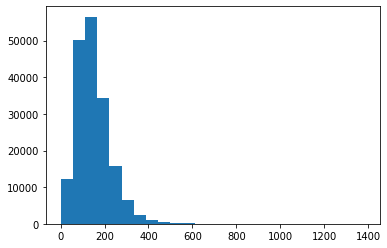

In [127]:
print(np.percentile(char_length,96))
plt.hist(char_length,bins=25);
# Maybe we can use 304 as embedding dimension

In [128]:
# The vocabulary of chars is the number of unique characters.
# Getting all keyboard chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [129]:
# Create a character level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 is for space " " and OOV or UNK token, out of vocabulary
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=300, # np.percentile(char_length,96)
                                   name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [130]:
# Character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print("Unique chars:",len(char_vocab))
print("Most common:",char_vocab[:5])
print("Most uncommon:",char_vocab[-5:])

Unique chars: 28
Most common: ['', '[UNK]', 'e', 't', 'i']
Most uncommon: ['k', 'x', 'z', 'q', 'j']


In [131]:
r = random.choice(train_chars)
print(r)
char_vectorizer([r])

g h s   c o m p l e t e r s   w i l l   b e   r a n d o m i s e d   t o   t h e   @ - m o n t h   e x t e n d e d   c o n t a c t   i n t e r v e n t i o n   (   g e t   h e a l t h y   ,   s t a y   h e a l t h y   ,   g h s h   )   o r   a   n o   c o n t a c t   c o n t r o l   g r o u p   (   s t a n d a r d   p r a c t i c e   f o l l o w i n g   g h s   c o m p l e t i o n   )   .


<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[18, 13,  9, 11,  7, 15, 14, 12,  2,  3,  2,  8,  9, 20,  4, 12,
        12, 22,  2,  8,  5,  6, 10,  7, 15,  4,  9,  2, 10,  3,  7,  3,
        13,  2, 15,  7,  6,  3, 13,  2, 24,  3,  2,  6, 10,  2, 10, 11,
         7,  6,  3,  5, 11,  3,  4,  6,  3,  2,  8, 21,  2,  6,  3,  4,
         7,  6, 18,  2,  3, 13,  2,  5, 12,  3, 13, 19,  9,  3,  5, 19,
        13,  2,  5, 12,  3, 13, 19, 18, 13,  9, 13,  7,  8,  5,  6,  7,
        11,  7,  6,  3,  5, 11,  3, 11,  7,  6,  3,  8,  7, 12, 18,  8,
         7, 16, 14,  9,  3,  5,  6, 10,  5,  8, 10, 14,  8,  5, 11,  3,
         4, 11,  2, 17,  7, 12, 12,  7, 20,  4,  6, 18, 18, 13,  9, 11,
         7, 15, 14, 12,  2,  3,  4,  7,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [132]:
# Character level embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25, # As mentioned in the paper
                             mask_zero=True,
                             name="char_embed")

In [133]:
print("Text:",r)
print("Length:",len(r))
print("Embedding:",char_embed(char_vectorizer([r])))
print("Shape:",char_embed(char_vectorizer([r])).shape)
# Considering max sequence length(the 95 percentile), the last dimensions will be same
# because sentence only has 133 characters, so last 187 will be same

Text: g h s   c o m p l e t e r s   w i l l   b e   r a n d o m i s e d   t o   t h e   @ - m o n t h   e x t e n d e d   c o n t a c t   i n t e r v e n t i o n   (   g e t   h e a l t h y   ,   s t a y   h e a l t h y   ,   g h s h   )   o r   a   n o   c o n t a c t   c o n t r o l   g r o u p   (   s t a n d a r d   p r a c t i c e   f o l l o w i n g   g h s   c o m p l e t i o n   )   .
Length: 389
Embedding: tf.Tensor(
[[[-0.00549096  0.04328952  0.00184096 ... -0.02144815  0.02889131
   -0.02246094]
  [-0.0108619  -0.04590073  0.02236919 ... -0.02551246 -0.00066119
   -0.03824038]
  [ 0.01939206 -0.01306769 -0.00188212 ...  0.03308252 -0.02272629
   -0.00010326]
  ...
  [-0.04192923 -0.00875126  0.01135658 ...  0.02301294  0.02366057
    0.01321012]
  [-0.04192923 -0.00875126  0.01135658 ...  0.02301294  0.02366057
    0.01321012]
  [-0.04192923 -0.00875126  0.01135658 ...  0.02301294  0.02366057
    0.01321012]]], shape=(1, 300, 25), dtype=float32)
Shape: (1, 300, 25)


## Creating fast loading dataset

In [134]:
char_train_fast_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
char_val_fast_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
char_test_fast_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

## Conv1D model (with character level embedding)

In [135]:
# Building the model
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
print(x.shape)
x = layers.Conv1D(64,10,padding='same')(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs = layers.Dense(5,activation='softmax')(x)
model4 = tf.keras.Model(inputs,outputs)

model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(None, 300, 25)
(None, 300, 64)
(None, 64)


In [136]:
model4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 300)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 300, 25)           700       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 300, 64)           16064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_______________________________________________________

In [137]:
h4 = model4.fit(char_train_fast_dataset,validation_data=char_val_fast_dataset,epochs=5,
               steps_per_epoch=int(0.1*len(char_train_fast_dataset)),
               validation_steps=int(0.1*len(char_val_fast_dataset)))
# GlobalMaxPool gives better validation accuracy than GlobalAveragePooling

Epoch 1/5
562/562 [==============================] - 3s 5ms/step - loss: 1.2339 - accuracy: 0.4988 - val_loss: 1.0023 - val_accuracy: 0.6027
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9517 - accuracy: 0.6270 - val_loss: 0.8941 - val_accuracy: 0.6509
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8737 - accuracy: 0.6613 - val_loss: 0.8190 - val_accuracy: 0.6835
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8208 - accuracy: 0.6877 - val_loss: 0.7887 - val_accuracy: 0.7035
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.7950 - accuracy: 0.7003 - val_loss: 0.7668 - val_accuracy: 0.7035


In [138]:
model4_results = calculate_results(val_labels_encoded,tf.argmax(model4.predict(char_val_fast_dataset),axis=1))
model4_results

{'accuracy': 70.17741294849729,
 'precision': 0.7059458214070449,
 'recall': 0.7017741294849729,
 'f1': 0.6987055057595876}

## Combining character and token embeddings
1. Build a model using token embedding, like model1 or pre-trained token embedding, like model2
2. Build a model using character embedding, like model4
3. Combine the two models.

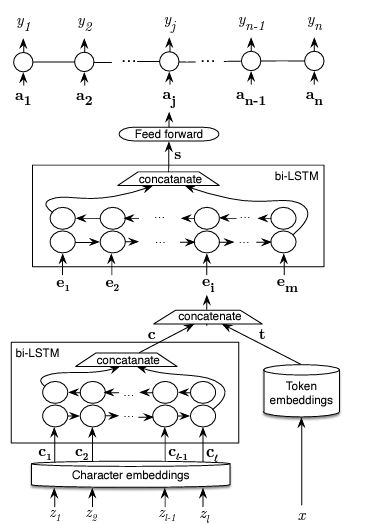

In [147]:
# 1. Token embedding model
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_inputs')
token_embeddings = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                trainable=False,
                name="universal_sentence_encoder")(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

# 2. Character embedding model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24,return_sequences=True))(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_bi_lstm)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# 3. Concatenate the token and char embeddings, something like a hybrid
token_char_concat = layers.Concatenate(name="token_char_hybrid",
                                      )([token_model.output,char_model.output])

# 4. Building output layers on top of this. Adding dropout.
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation='softmax')(final_dropout)

# 5. Building the combined model
model5 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model5_token_char_hybrid"
                       )

In [148]:
model5.summary()

Model: "model5_token_char_hybrid"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 300)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 300, 25)      700         char_vectorizer[2][0]            
___________________________________________________________________________

## Plot hybrid model

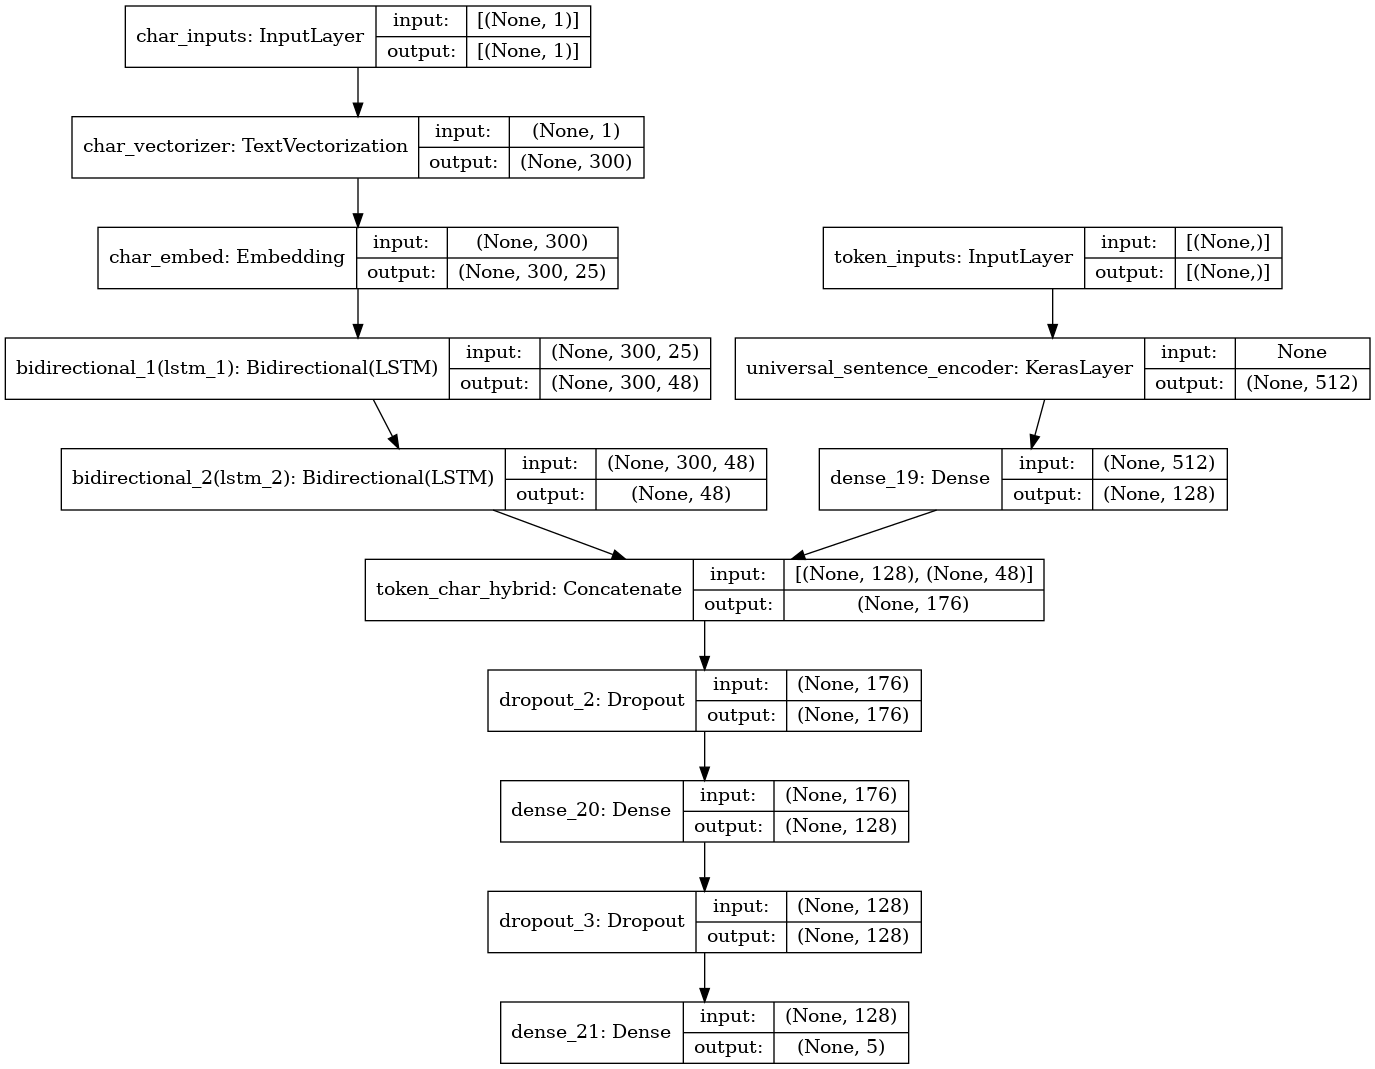

In [149]:
from tensorflow.keras.utils import plot_model
plot_model(model5,show_shapes=True)

In [150]:
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Multi-input fast loading

In [143]:
# For training data
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data, order matters as in model
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data,train_char_token_labels)) # combine data and labels

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data,val_char_token_labels)) # combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For test data
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_token_char_data,test_char_token_labels)) # combine data and labels

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [151]:
h5 = model5.fit(train_char_token_dataset,validation_data=val_char_token_dataset,
               epochs=5,
               steps_per_epoch=int(0.1*len(train_char_token_dataset)),
               validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 64s 89ms/step - loss: 0.9691 - accuracy: 0.6130 - val_loss: 0.7743 - val_accuracy: 0.7005
Epoch 2/5
562/562 [==============================] - 45s 80ms/step - loss: 0.7931 - accuracy: 0.6912 - val_loss: 0.6992 - val_accuracy: 0.7347
Epoch 3/5
562/562 [==============================] - 39s 69ms/step - loss: 0.7663 - accuracy: 0.7111 - val_loss: 0.6783 - val_accuracy: 0.7487
Epoch 4/5
562/562 [==============================] - 47s 83ms/step - loss: 0.7342 - accuracy: 0.7237 - val_loss: 0.6582 - val_accuracy: 0.7520
Epoch 5/5
562/562 [==============================] - 42s 74ms/step - loss: 0.7405 - accuracy: 0.7200 - val_loss: 0.6499 - val_accuracy: 0.7490


In [152]:
model5_results = calculate_results(val_labels_encoded,tf.argmax(model5.predict(val_char_token_dataset),axis=1))
model5_results

{'accuracy': 74.57632728717066,
 'precision': 0.7426061876717374,
 'recall': 0.7457632728717066,
 'f1': 0.739699867556258}

In [146]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

<AxesSubplot:>

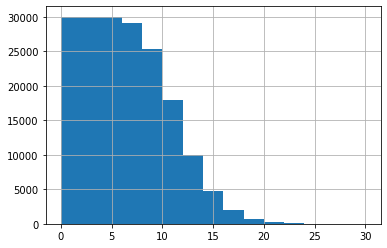

In [155]:
# checking distribution of line numbers
train_df['line_number'].hist(bins=15)

## Using TensorFlow to One-Hot-Encode the line numbers.

In [157]:
train_ln_oh = tf.one_hot(train_df['line_number'].to_numpy(),depth=20)
val_ln_oh = tf.one_hot(val_df['line_number'].to_numpy(),depth=20)
test_ln_oh = tf.one_hot(test_df['line_number'].to_numpy(),depth=20)
print(train_ln_oh.shape)
print(train_ln_oh[:5])

(180040, 20)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 20), dtype=float32)


## Also encode the `total lines` feature.

<AxesSubplot:>

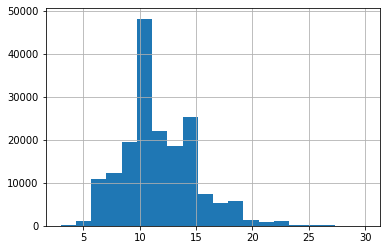

In [160]:
train_df['total_lines'].hist(bins=20)

In [161]:
train_tl_oh = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_tl_oh = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_tl_oh = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)
print(train_tl_oh.shape)
print(train_tl_oh[:5])

(180040, 20)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 20), dtype=float32)


In [162]:
# Keep the embedding layer ready
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                trainable=False,
                name="universal_sentence_encoder")

## Building a tribrid embedding model
1. Create token level model
2. Create a character level model
3. Create a model for `line_number` feature
4. Create a model for `total_lines` feature
5. Combine outputs of 1 and 2 using concatenate
6. Combine 3, 4 and 5 using concatenate
7. Create an output layer to accept the tribrid embedding and output probabilities
8. Combine inputs of 1,2,3 and 4 with outputs into a Model

In [186]:
# 1. Token inputs
token_inputs_tribrid = layers.Input(shape=[],dtype=tf.string,name="token_input_layer")
token_embeddings = tf_hub_embedding_layer(token_inputs_tribrid)
token_outputs_tribrid = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs_tribrid,
                             outputs = token_outputs_tribrid,
                             name="token_level_model")

# 2. Character inputs
char_inputs_tribrid = layers.Input(shape=(1,),dtype=tf.string,name="char_input_layer")
char_vectorized = char_vectorizer(char_inputs_tribrid)
char_embeddings = char_embed(char_vectorized)
char_bi_lstm_tribrid = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs_tribrid,char_bi_lstm_tribrid,name="char_level_model")

# 3. Line numbers Model
ln_inputs = layers.Input(shape=(20,),name="line_numbers_input",dtype=tf.float32) # Input shape is (20,) because each one hot vector(is 20 length long) has 20 entries 😅.
ln_dense1 = layers.Dense(32,activation='relu')(ln_inputs)
ln_model = tf.keras.Model(ln_inputs,ln_dense1,name="line_number_model")

# 4. Total lines Model
tl_inputs = layers.Input(shape=(20,),name="total_lines_input",dtype=tf.float32)
tl_dense1 = layers.Dense(32,activation='relu')(tl_inputs)
tl_model = tf.keras.Model(tl_inputs,tl_dense1,name="total_lines_model")

# 5. Combine outputs of 1 and 2
token_char_combined_embedding = layers.Concatenate(
    name="token_char_embedding")([
    token_model.output,
    char_model.output])
z = layers.Dense(256,activation='relu')(token_char_combined_embedding)
z = layers.Dropout(0.5)(z)


# 6. Combine outputs of 3, 4 and 5 i.e. line number + total lines + hybrid 
tribrid_embedding = layers.Concatenate(
    name="tribrid_embedding")([ln_model.output,
                               tl_model.output,
                               z])

# 7. Create output layer
output_layer = layers.Dense(5,activation="softmax")(tribrid_embedding)

# 8. Make a model
tribrid_model = tf.keras.Model(
    inputs=[ln_model.input,
            tl_model.input,
            token_model.input,
            char_model.input
           ], 
    outputs=output_layer, name="tribid_embedding_model")

In [174]:
tribrid_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input_layer (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 300)          0           char_input_layer[0][0]           
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input_layer[0][0]          
___________________________________________________________________________________________

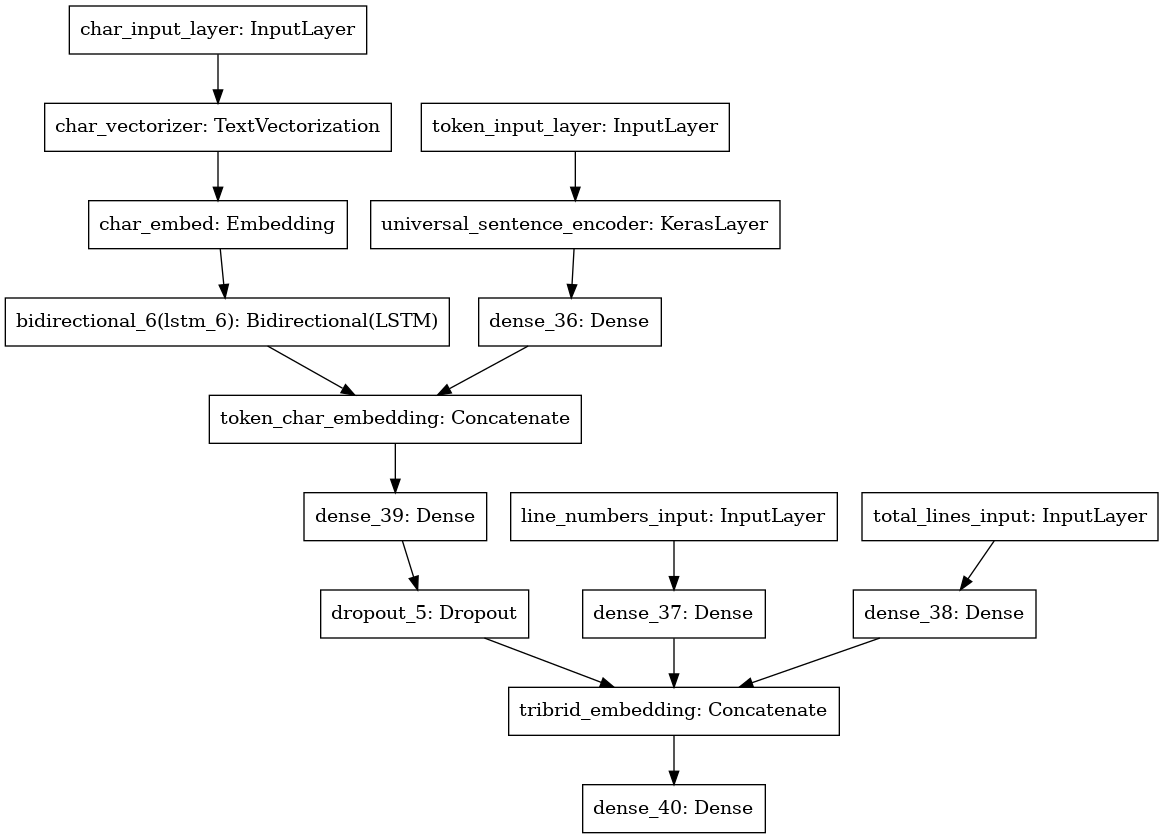

In [175]:
plot_model(tribrid_model)

In [187]:
# Compile the token, char, and positional embedding model
tribrid_model.compile(
    # Label smoothing helps to avoid overfitting
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer='adam',
    metrics=['accuracy']
)

## Creating multi-level data input

In [188]:
# For training data
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_ln_oh, 
                                                         train_tl_oh, 
                                                         train_sentences,
                                                         train_chars)) # make data, order matters as in model
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data,train_tribrid_labels)) # combine data and labels
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation data
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_ln_oh, 
                                                       val_tl_oh, 
                                                       val_sentences,
                                                       val_chars)) # make data, order matters as in model
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data,val_tribrid_labels)) # combine data and labels
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For testing data
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_ln_oh, 
                                                        test_tl_oh, 
                                                        test_sentences,
                                                        test_chars)) # make data, order matters as in model
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data,test_tribrid_labels)) # combine data and labels
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [189]:
train_tribrid_dataset

<PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [190]:
tribrid_history = tribrid_model.fit(train_tribrid_dataset,
                                   validation_data=val_tribrid_dataset,
                                   steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                                   validation_steps=int(0.1*len(val_tribrid_dataset)),
                                   epochs=5)

Epoch 1/5
562/562 [==============================] - 36s 51ms/step - loss: 1.0944 - accuracy: 0.7249 - val_loss: 0.9804 - val_accuracy: 0.8055
Epoch 2/5
562/562 [==============================] - 26s 47ms/step - loss: 0.9642 - accuracy: 0.8206 - val_loss: 0.9466 - val_accuracy: 0.8324
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9466 - accuracy: 0.8245 - val_loss: 0.9355 - val_accuracy: 0.8318
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9354 - accuracy: 0.8390 - val_loss: 0.9272 - val_accuracy: 0.8361
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9345 - accuracy: 0.8380 - val_loss: 0.9213 - val_accuracy: 0.8467


In [191]:
tribrid_probs = tribrid_model.predict(val_tribrid_dataset)
tribrid_preds = tf.argmax(tribrid_probs,axis=1)
tribrid_results = calculate_results(val_labels_encoded,tribrid_preds)

In [192]:
tribrid_results

{'accuracy': 84.59883490003972,
 'precision': 0.8480123036628224,
 'recall': 0.8459883490003972,
 'f1': 0.8422669758215345}

In [197]:
comparison = pd.DataFrame({
    "Naive Bayes Model":baseline_results,
    "Custom token embedding model":model1_results,
    "Pretrained token embedding model":model2_results,
    "Conv1D with pretrained embeddings":model3_results,
    "Character embeddings with Conv1D":model4_results,
    "Token and Character hybrid":model5_results,
    "Token-Character-Position tribrid":tribrid_results
}).transpose()

In [198]:
comparison

,accuracy,precision,recall,f1
Naive Bayes Model,72.183238,0.718647,0.721832,0.698925
Custom token embedding model,79.312856,0.799132,0.793129,0.792421
Pretrained token embedding model,75.324374,0.750471,0.753244,0.749083
Conv1D with pretrained embeddings,70.101284,0.699093,0.701013,0.695680
Character embeddings with Conv1D,70.177413,0.705946,0.701774,0.698706
Token and Character hybrid,74.576327,0.742606,0.745763,0.739700
Token-Character-Position tribrid,84.598835,0.848012,0.845988,0.842267


In [199]:
# Reduce the accuracy to same scale as other metrics
comparison["accuracy"] = comparison["accuracy"]/100

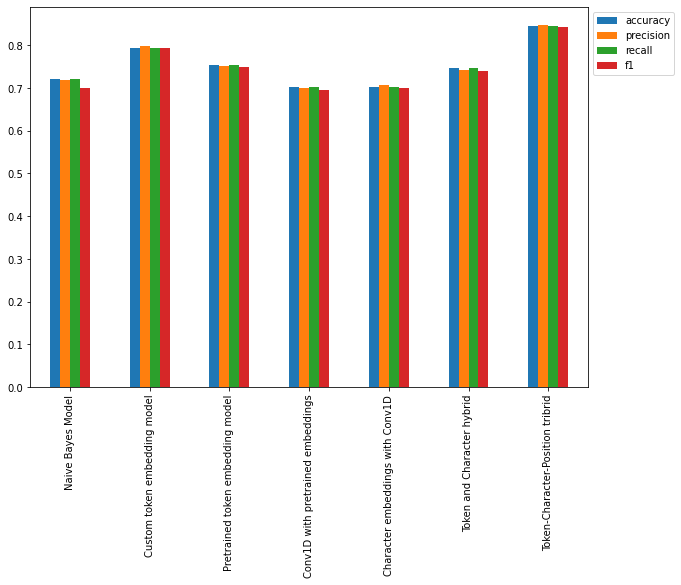

In [200]:
# Plot and compare all model results
comparison.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [201]:
# Save the best performing model to SavedModel format (default)
tribrid_model.save("skimlit_tribrid_model")

2022-09-18 12:16:13.499407: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [204]:
test_probs = tribrid_model.predict(test_tribrid_dataset)
test_preds = tf.argmax(test_probs,axis=1)
test_results = calculate_results(test_labels_encoded,test_preds)

In [205]:
test_results

{'accuracy': 84.07499585199933,
 'precision': 0.8423789770148898,
 'recall': 0.8407499585199933,
 'f1': 0.837083144541984}

In [207]:
len(test_df),len(test_preds)

(30135, 30135)

In [211]:
test_df['prediction'] = label_encoder.inverse_transform(test_preds)

In [214]:
test_probs

array([[0.2917519 , 0.1017213 , 0.11326959, 0.41824844, 0.07500886],
       [0.26046976, 0.06379867, 0.3736891 , 0.2564642 , 0.04557827],
       [0.05197896, 0.02111833, 0.82927966, 0.06421357, 0.03340948],
       ...,
       [0.05594342, 0.22349194, 0.04495149, 0.03537674, 0.64023644],
       [0.04388216, 0.13098808, 0.04856545, 0.03244852, 0.7441158 ],
       [0.06581572, 0.5730033 , 0.15112144, 0.02813758, 0.18192193]],
      dtype=float32)

In [212]:
wrong_predictions = test_df[test_df['target']!=test_df['prediction']]

In [213]:
wrong_predictions

,target,text,line_number,total_lines,prediction
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS
...,...,...,...,...,...
30095,OBJECTIVE,this study represents the first large multicen...,1,12,BACKGROUND
30108,BACKGROUND,we compared results of sputum culture conversi...,1,9,METHODS
30113,RESULTS,sputum culture conversion was analyzed in @ ( ...,6,9,METHODS
30119,BACKGROUND,the alfredson protocol recommends the completi...,2,17,METHODS
